<a href="https://colab.research.google.com/github/MihaelaHudisteanu/Neural-Networks-2024/blob/main/Assignment03Done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [ ]:
def download_mnist(is_train: bool):
    dataset = MNIST(root='./data',
                    transform=lambda x: np.array(x).flatten(),
                    download=True,
                    train=is_train)
    mnist_data = []
    mnist_labels = []
    for image, label in dataset:
        mnist_data.append(image)
        mnist_labels.append(label)
    return mnist_data, mnist_labels

In [ ]:
def one_hot_encode(y, num_classes):
    one_hot_y = np.zeros((len(y), num_classes))

    for i in range(len(y)):
        one_hot_y[i, y[i]] = 1

    return one_hot_y

In [ ]:
def normalize(x, max_value):
    return np.array(x).astype(np.float32) / max_value

In [ ]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [ ]:
def cross_entropy_loss(predictions, labels):
    epsilon = 1e-10
    return -np.mean(np.sum(labels * np.log(predictions + epsilon), axis=1))

In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    W_hidden = np.random.randn(input_size, hidden_size) * 0.01
    b_hidden = np.zeros((1, hidden_size))
    W_output = np.random.randn(hidden_size, output_size) * 0.01
    b_output = np.zeros((1, output_size))
    return W_hidden, b_hidden, W_output, b_output

In [ ]:
def relu(x):
    return np.maximum(0, x)

In [ ]:
def forward(x, W_hidden, b_hidden, W_output, b_output):
    z_hidden = np.dot(x, W_hidden) + b_hidden
    a_hidden = relu(z_hidden)
    z_output = np.dot(a_hidden, W_output) + b_output
    y_pred = softmax(z_output)
    return z_hidden, a_hidden, z_output, y_pred

In [ ]:
def relu_derivative(x):
    return (x > 0).astype(float)

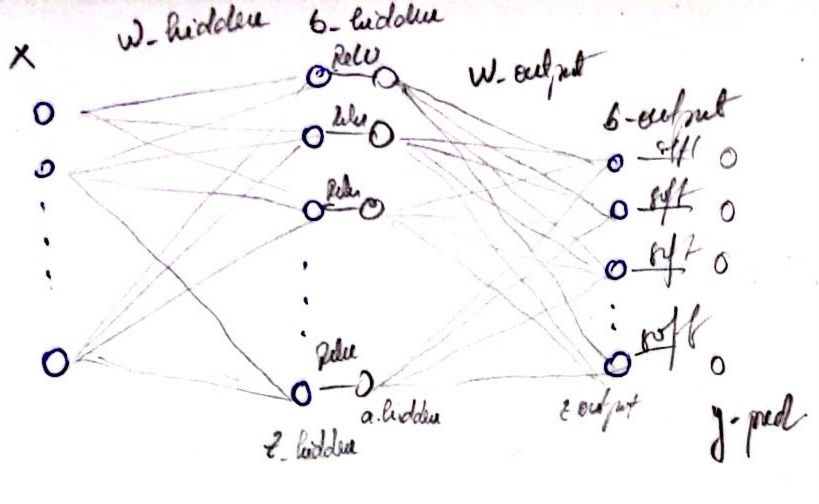
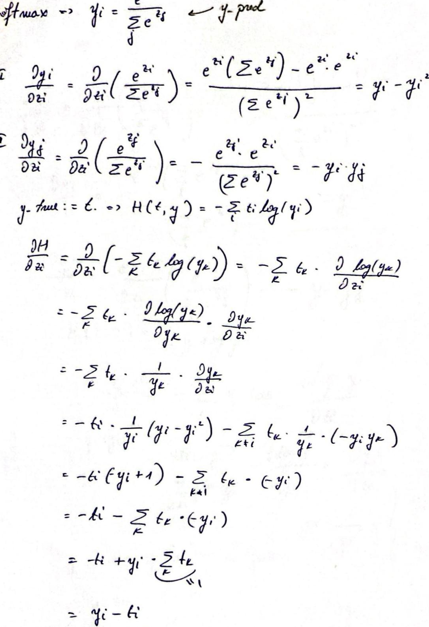

In [ ]:
def backward(x, y_true, z_hidden, a_hidden, y_pred, W_hidden, b_hidden, W_output, b_output, learning_rate):
    #gradients output layer
    dz_output = y_pred - y_true
    dW_output = np.dot(a_hidden.T, dz_output)  #dH/dW_output = dH/dz_output * dz_output/dW_output & z_output = a_hidden*W_output + b_output
    db_output = np.sum(dz_output, axis=0, keepdims=True)

    #gradients hidden layer
    da_hidden = np.dot(dz_output, W_output.T)
    dz_hidden = da_hidden * relu_derivative(z_hidden)
    dW_hidden = np.dot(x.T, dz_hidden)
    db_hidden = np.sum(dz_hidden, axis=0, keepdims=True)

    #update rules
    W_hidden -= learning_rate * dW_hidden
    b_hidden -= learning_rate * db_hidden
    W_output -= learning_rate * dW_output
    b_output -= learning_rate * db_output

    return W_hidden, b_hidden, W_output, b_output

In [ ]:
def train(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=20, batch_size=100, learning_rate=0.01):
    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train = x_train[permutation]
        y_train = y_train[permutation]

        # split
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            z_hidden, a_hidden, z_output, y_pred = forward(x_batch, W_hidden, b_hidden, W_output, b_output)
            loss = cross_entropy_loss(y_batch, y_pred)
            W_hidden, b_hidden, W_output, b_output = backward(x_batch, y_batch, z_hidden, a_hidden, y_pred, W_hidden, b_hidden,
                                                              W_output, b_output, learning_rate)

        if epoch % 10 == 0:
            print("Epoch " + str(epoch + 10) + " has error: " + str(loss))

    return W_hidden, b_hidden, W_output, b_output

In [ ]:
def accuracy(x, y, W_hidden, b_hidden, W_output, b_output):
    _, _, _, y_pred = forward(x, W_hidden, b_hidden, W_output, b_output)
    predictions = np.argmax(y_pred, axis=1)
    labels = np.argmax(y, axis=1)
    return np.mean(predictions == labels) * 100

In [ ]:
if __name__ == "__main__":
    x_train, y_train = download_mnist(True)
    x_test, y_test = download_mnist(False)

    x_train = normalize(x_train, 255.0)
    x_test = normalize(x_test, 255.0)

    y_train = one_hot_encode(y_train, 10)
    y_test = one_hot_encode(y_test, 10)

    W_hidden, b_hidden, W_output, b_output = initialize_parameters(len(x_train[0]), 100, 10)

    W_hidden, b_hidden, W_output, b_output = train(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=100, learning_rate=0.01)

    test_acc = accuracy(x_test, y_test, W_hidden, b_hidden, W_output, b_output)
    print('Test accuracy after training: ' + str(test_acc) + '%')

Epoch 10 has error: 2.2156295547310068
Epoch 20 has error: 0.39318576991296433
Epoch 30 has error: 0.5614838111596167
Epoch 40 has error: 0.1945994736408608
Epoch 50 has error: 0.20953343443376343
Epoch 60 has error: 0.017865780557869103
Epoch 70 has error: 0.2594659301684055
Epoch 80 has error: 0.010733182468132617
Epoch 90 has error: 0.0018888065935068687
Epoch 100 has error: 0.004708189015998526
Test accuracy after training: 97.04%


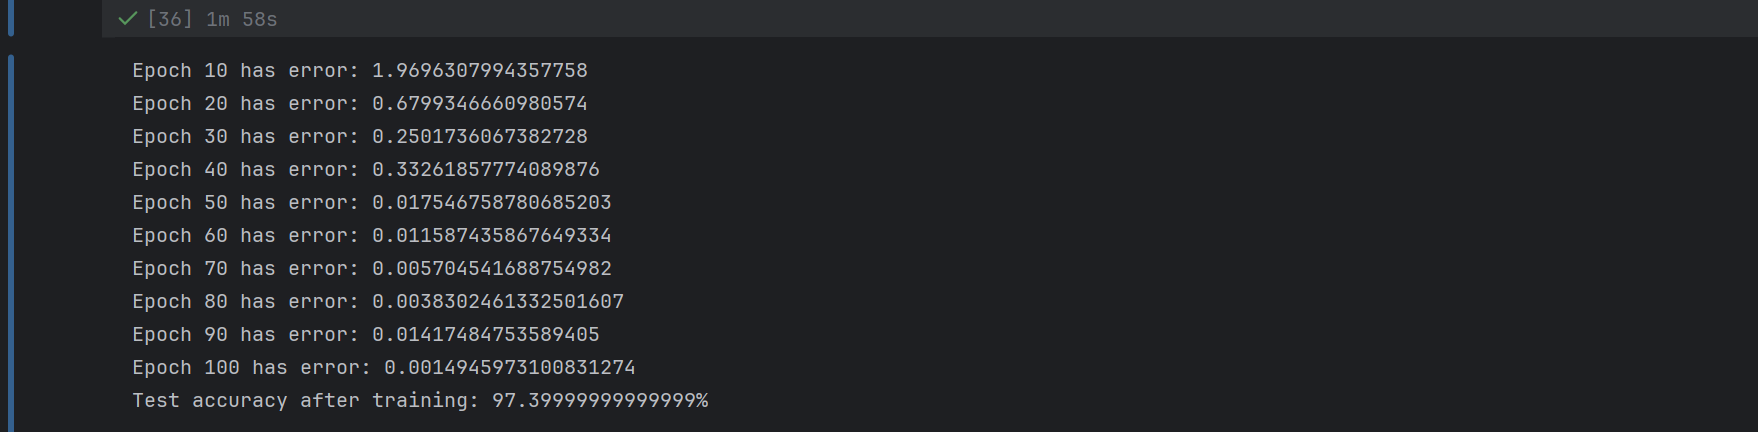

In [ ]:
def train_with_decay(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=20, batch_size=100, patience=5, decay_factor=0.5, learning_rate=0.01):

    learning_rate_with_decay = learning_rate
    min_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train = x_train[permutation]
        y_train = y_train[permutation]

        # split
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            z_hidden, a_hidden, z_output, y_pred = forward(x_batch, W_hidden, b_hidden, W_output, b_output)
            loss = cross_entropy_loss(y_batch, y_pred)
            W_hidden, b_hidden, W_output, b_output = backward(x_batch, y_batch, z_hidden, a_hidden, y_pred, W_hidden, b_hidden,
                                                              W_output, b_output, learning_rate)
        if loss < min_loss:
            min_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            learning_rate_with_decay *= decay_factor
            patience_counter = 0
            print("Learning rate decays")
        if epoch % 10 == 0:
            print("Epoch " + str(epoch + 10) + " has error: " + str(loss))

    return W_hidden, b_hidden, W_output, b_output

In [ ]:
if __name__ == "__main__":
    x_train, y_train = download_mnist(True)
    x_test, y_test = download_mnist(False)

    x_train = normalize(x_train, 255.0)
    x_test = normalize(x_test, 255.0)

    y_train = one_hot_encode(y_train, 10)
    y_test = one_hot_encode(y_test, 10)

    W_hidden, b_hidden, W_output, b_output = initialize_parameters(len(x_train[0]), 100, 10)

    #W_hidden, b_hidden, W_output, b_output = train(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=100, learning_rate=0.01)

    W_hidden, b_hidden, W_output, b_output = train_with_decay(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=100, patience=5, decay_factor=0.5, learning_rate=0.01)

    test_acc = accuracy(x_test, y_test, W_hidden, b_hidden, W_output, b_output)
    print('Test accuracy after training: ' + str(test_acc) + '%')

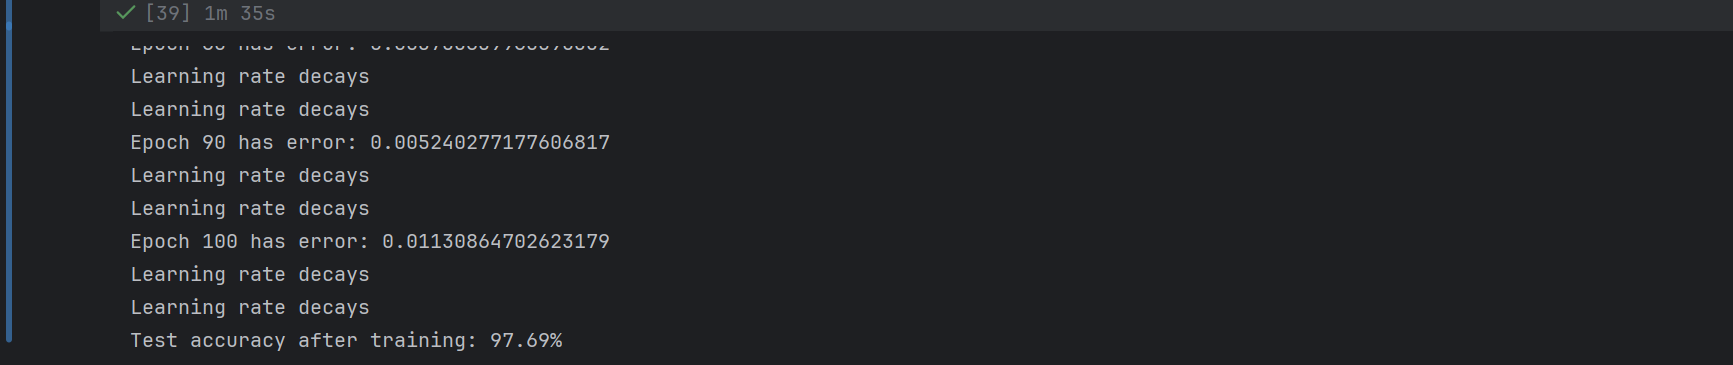

decay_factor = 0.9
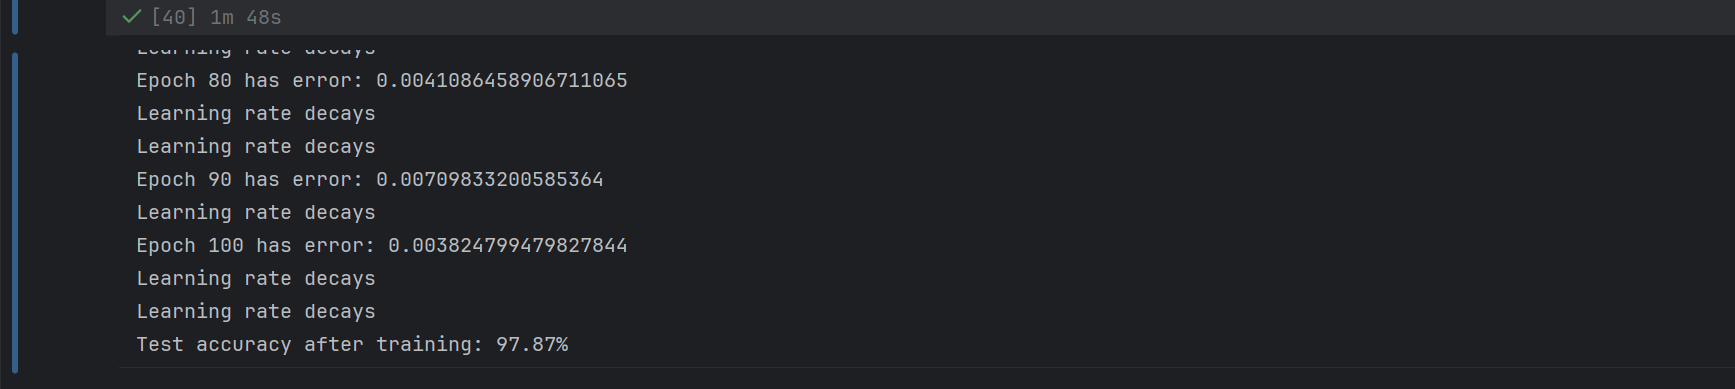

In [ ]:
def cross_entropy_loss_L2reg(predictions, labels, W_hidden, W_output, lambda_reg):
    epsilon = 1e-10
    #L2 regularization helps with overfitting by penalizing large weights in the model
    loss = -np.mean(np.sum(labels * np.log(predictions + epsilon), axis=1)) + lambda_reg * (np.sum(W_hidden**2) + np.sum(W_output**2))
    return loss


In [ ]:
def backward_L2reg(x, y_true, z_hidden, a_hidden, y_pred, W_hidden, b_hidden, W_output, b_output, learning_rate, lambda_reg):
    #gradients output layer
    dz_output = y_pred - y_true
    dW_output = np.dot(a_hidden.T, dz_output) + lambda_reg * W_output
    db_output = np.sum(dz_output, axis=0, keepdims=True)

    #gradients hidden layer
    da_hidden = np.dot(dz_output, W_output.T)
    dz_hidden = da_hidden * relu_derivative(z_hidden)
    dW_hidden = np.dot(x.T, dz_hidden) + lambda_reg * W_hidden
    db_hidden = np.sum(dz_hidden, axis=0, keepdims=True)

    #update rules
    W_hidden -= learning_rate * dW_hidden
    b_hidden -= learning_rate * db_hidden
    W_output -= learning_rate * dW_output
    b_output -= learning_rate * db_output

    return W_hidden, b_hidden, W_output, b_output


In [ ]:
def train_L2reg(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=20, batch_size=100, learning_rate=0.01, lambda_reg=0.001):
    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train = x_train[permutation]
        y_train = y_train[permutation]

        #split
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            z_hidden, a_hidden, z_output, y_pred = forward(x_batch, W_hidden, b_hidden, W_output, b_output)
            loss = cross_entropy_loss_L2reg(y_batch, y_pred, W_hidden, W_output, lambda_reg)
            W_hidden, b_hidden, W_output, b_output = backward_L2reg(x_batch, y_batch, z_hidden, a_hidden, y_pred, W_hidden, b_hidden,
                                                              W_output, b_output, learning_rate, lambda_reg)

        if epoch % 10 == 0:
            print("Epoch " + str(epoch) + " has error: " + str(loss))

    return W_hidden, b_hidden, W_output, b_output


In [ ]:
if __name__ == "__main__":
    x_train, y_train = download_mnist(True)
    x_test, y_test = download_mnist(False)

    x_train = normalize(x_train, 255.0)
    x_test = normalize(x_test, 255.0)

    y_train = one_hot_encode(y_train, 10)
    y_test = one_hot_encode(y_test, 10)

    W_hidden, b_hidden, W_output, b_output = initialize_parameters(len(x_train[0]), 100, 10)

    W_hidden, b_hidden, W_output, b_output = train_L2reg(x_train, y_train, W_hidden, b_hidden, W_output, b_output, epochs=100, learning_rate=0.01, lambda_reg=0.001)

    test_acc = accuracy(x_test, y_test, W_hidden, b_hidden, W_output, b_output)
    print('Test accuracy after training: ' + str(test_acc) + '%')


Epoch 0 has error: 1.9558806073094905
Epoch 10 has error: 1.2771500628755263
Epoch 20 has error: 1.2702554646886202
Epoch 30 has error: 1.1663362159472135
Epoch 40 has error: 1.1440462954712953
Epoch 50 has error: 1.0998057780759338
Epoch 60 has error: 1.0840685200850793
Epoch 70 has error: 1.0824231055345985
Epoch 80 has error: 1.0257440158859539
Epoch 90 has error: 1.0282122753452765
Test accuracy after training: 98.02%
